Linus code

In [1]:
# Install package to be able to save keras weights
pip install h5py

In [2]:
pip install nibabel

In [3]:
# Mount google drive
from google.colab import drive
import os
drive.mount('my_drive', force_remount=True)

Mounted at my_drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import keras.backend as K
import json
import psutil
import glob
import nibabel as nib
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from sklearn.preprocessing import normalize
from scipy.ndimage import zoom


def print_memory_use():
    '''
    Function which prints current python memory usage
    '''
    process = psutil.Process(os.getpid())
    print(process.memory_info().rss/1e9)

# What value maps to what class
mapping = {
    0: "Null class",
    1: "Necrotic and non-enhancing tumor core",
    2: "Edema",
    4: "GD-enhancing tumor"
}

mapping2 = {
    0: "Null class",
    1: "Tumor",
}

def shift_and_scale(x):
    assert len(x.shape) == 2, 'The input must be 2 dimensional'
    # assert np.std(x) != 0, 'Cant divide by zero'
    result = x - np.mean(x)

    # This is a really ugly hack
    if np.std(x) == 0:
        result /= 1
    else:
        result /= np.std(x)
    return result

def OHE(Y):
    '''
    :param Y: A slice containing original BraTS-data with classes {0,1,2,4}
    :return: A slice where classes 1 and 4 has been merged and this has been one hot encoded
    '''
    shape = Y.shape
    one_hot_enc = np.zeros(list(shape) + [2])
    temp = np.zeros(shape)
    temp2 = np.ones(shape)
    
    ind1 = Y == 1
    ind2 = Y == 4
    temp[ind1] = 1
    temp[ind2] = 1
    
    temp2 = temp2 - temp
    
    one_hot_enc[:, :, 0] = temp
    one_hot_enc[:, :, 1] = temp2
    return one_hot_enc

def OHE_uncoding(y, mapping):
    result = np.argmax(y, axis=2)
    labels = mapping.keys()
    temp = np.zeros(result.shape)
    for i, label in enumerate(labels):
        ind = result == i
        temp[ind] = label
    return temp

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true[:, 0])
    y_pred_f = K.flatten(y_pred[:, 0])
    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    return (2. * intersection) / (
        K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + 1e-8)

def IoU(y_true, y_pred):
    intersection = K.sum(y_true[:, 0]*y_pred[:, 0])
    sum_ = K.sum(K.abs(y_true[:, 0]) + K.abs(y_pred[:, 0]))
    return intersection/sum_

def reset_config(config, config_path=None, weights_path=None):
    new_config = config
    if weights_path:
        assert type(weights_path) == str, 'The weight path must be a string'
        new_config['weights_path'] = weights_path
    if config_path:
        assert type(config_path) == str, 'The config path must be a string'
        new_config['config_path'] = config_path
    new_config['history']['training_samples_used'] = 0
    new_config['history']['loss'] = []
    new_config['history']['val_loss'] = []
    new_config['keep_training'] = False

class CallbackJSON(Callback):
    """ CallbackJSON descends from Callback
        and is used to write the number of training samples that the model has been trained on
        and the loss for a epoch
    """
    def __init__(self, config):
        """Save params in constructor
        config: Is a dictionary loaded from a JSON file which is used to keep track of training
        """
        self.config = config
        self.config_path = config['config_path']

    def on_epoch_end(self, epoch, logs):
        """
        Updates the history of the config dict and saves it to a file
        """
        # How many effective training samples have been used
        self.config['history']['training_samples_used'] += self.config['samples_used']
        
        # Logs the loss of the current epoch
        self.config['history']['loss'].append(logs['loss'])
        #fixme: add the same code but for "val_loss"
        self.config['history']['val_loss'].append(logs['val_loss'])
        
        print_memory_use()
        # Save new config file
        with open(self.config_path, "w") as f:
            f.write(json.dumps(self.config))

def load_patients(i, j, base_path="", rescale=None):
    '''
    Function which loads patients from BraTS data
    :param i: First patient to be loaded
    :param j: From patient i to j load all patients
    :param base_path: Specifies where data is
    :return: A tuple with data in the first place and labels in the second place.
    Data has shape (n,240,240,1) where n is the number of slices from patient i to j who contains tumors
    and the labels has has shape (n, 240, 240, 2) which is a pixelwise binary softmax.
    '''
    assert j >= i, 'j>i has to be true, you have given an invalid range of patients.'
    path = base_path + "MICCAI_BraTS_2019_Data_Training/*/*/*"
    wild_t1ce = path + "_t1ce.nii.gz"
    wild_gt = path + "_seg.nii.gz"

    t1ce_paths = glob.glob(wild_t1ce)
    gt_paths = glob.glob(wild_gt)

    num_patients = j - i
    ind = []
    #fixme: the list and the set patients should be made into a dictionary
    patients = set({})
    num_non_empty_slices = 0
    labels_of_interest = set([1, 4])

    for k in range(i, j):
        path_gt = gt_paths[k]
        img_gt = nib.load(path_gt)
        img_gt = img_gt.get_fdata()
        curr_patient = []
        for l in range(img_gt.shape[-1]):
            labels_in_slice = set(np.unique(img_gt[:, :, l]))
            if labels_of_interest.issubset(labels_in_slice):
                curr_patient.append(l)
                num_non_empty_slices += 1
                patients.add(k)
        if len(curr_patient) > 0:
            ind.append(curr_patient)

    image_data = np.zeros((1, 240, 240, num_non_empty_slices))
    labels = np.zeros((num_non_empty_slices, 240, 240))
    OHE_labels = np.zeros((num_non_empty_slices, 240, 240, 2))
    next_ind = 0

    for k, y in enumerate(patients):
        print('Patient: ' + str(y))
        curr_ind = ind[k]

        path_t1ce = t1ce_paths[y]
        path_gt = gt_paths[y]

        img_t1ce = nib.load(path_t1ce)
        img_gt = nib.load(path_gt)

        img_t1ce = img_t1ce.get_fdata()
        img_gt = img_gt.get_fdata()

        # This code is necessary when we will use the data from Asgeir
        if rescale:
            img_gt = zoom(img_gt, rescale, order=0)
            img_t1ce = zoom(img_t1ce, rescale, order=0)

        temp = 0
        for l, x in enumerate(curr_ind):
            image_data[0, :, :, next_ind + l] = img_t1ce[:, :, x]
            labels[next_ind + l, :, :] = img_gt[:, :, x]
            temp += 1
        next_ind += temp

    for l in range(num_non_empty_slices):
        image_data[0, :, :, l] = normalize(image_data[0, :, :, l])
        OHE_labels[l, :, :, :] = OHE(labels[l, :, :])

    # The last axis will become the first axis
    image_data = np.moveaxis(image_data, -1, 0)
    image_data = np.moveaxis(image_data, 1, 3)
    return (image_data, OHE_labels, patients)

def conv_block(input_, num_kernels, kernel_size, act_func, drop_rate):
    conv = Conv2D(num_kernels, kernel_size,activation = act_func, padding = 'same', kernel_initializer = 'he_normal')(input_)
    conv = Conv2D(num_kernels, kernel_size, activation = act_func, padding = 'same', kernel_initializer = 'he_normal')(conv)
    drop = Dropout(drop_rate)(conv)
    return conv

def conv_block(input_, num_kernels, kernel_size, act_func, drop_rate):
    argz = [num_kernels, kernel_size]
    kwargz = {'activation':act_func, 'padding':'same', 'kernel_initializer':'he_normal'}
    conv = Conv2D(*argz, **kwargz)(input_)
    conv = Conv2D(*argz, **kwargz)(conv)
    drop = Dropout(drop_rate)(conv)
    return conv

def conv_block_resnet(input_, num_kernels, kernel_size, act_func, drop_rate, input_size):
    argz = [num_kernels, kernel_size]
    kwargz = {'activation':act_func, 'padding':'same', 'kernel_initializer':'he_normal'}
    conv = Conv2D(*argz, **kwargz)(input_)
    conv = Conv2D(*argz, **kwargz)(conv)
    conv = Conv2D(input_size[-1], (1,1), activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Dropout(drop_rate)(conv)
    merge = Add()([input_, conv])
    merge = BatchNormalization()(merge)
    merge = Activation(act_func)(merge)
    return merge

def down_sampling_block(input_, act_func, num_kernels, drop_rate, input_size, res=False):
    if res:
        skip = conv_block_resnet(input_=input_, num_kernels=num_kernels, kernel_size=(3,3), 
                                 act_func=act_func, drop_rate=drop_rate, input_size=input_size)
    else:
        skip = conv_block(input_, num_kernels=num_kernels, kernel_size=(3,3), act_func=act_func, drop_rate=drop_rate)
    pool = MaxPooling2D(pool_size = (2, 2))(skip)
    return skip, pool

def up_sampling_block(input_, skip, act_func, num_kernels, drop_rate, input_size, res=False):
    up = UpSampling2D(size = (2, 2))(input_)
    merge = concatenate([skip, up], axis = 3)
    if res:
        conv = conv_block_resnet(up, num_kernels=num_kernels, kernel_size=(3,3), 
                                 act_func=act_func, drop_rate=drop_rate, input_size=input_size)
    else:
        conv = conv_block(merge, num_kernels, (3,3), act_func, drop_rate)
    return conv

def unet_clean(pretrained_weights = None, input_size = (256, 256, 1), num_classes=2, learning_rate=1e-4, act_func='relu', res=False):
    # Encoder
    inputs = Input(input_size)
    skip1, pool1 = down_sampling_block(inputs, act_func, num_kernels=64, drop_rate=0, input_size = input_size, res=res)
    skip2, pool2 = down_sampling_block(pool1, act_func, num_kernels=128, drop_rate=0, input_size = input_size, res=res)
    skip3, pool3 = down_sampling_block(pool2, act_func, num_kernels=256, drop_rate=0, input_size = input_size, res=res)
    skip4, pool4 = down_sampling_block(pool3, act_func, num_kernels=512, drop_rate=0.2, input_size = input_size, res=res)
    
    #Bottleneck
    conv5 = conv_block(pool4, 1024, 3, act_func, drop_rate=0.2)
    
    # Decoder
    conv6 = up_sampling_block(conv5, skip4, act_func, 512, drop_rate = 0.2, input_size = input_size, res=res)
    conv7 = up_sampling_block(conv6, skip3, act_func, 256, drop_rate = 0, input_size = input_size, res=res)
    conv8 = up_sampling_block(conv7, skip2, act_func, 128, drop_rate = 0, input_size = input_size, res=res)
    conv9 = up_sampling_block(conv8, skip1, act_func, 64, drop_rate = 0, input_size = input_size, res=res)
    conv9 = Conv2D(num_classes, 1, activation = act_func, padding = 'same', kernel_initializer = 'he_normal')(conv9)

    reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv9)
    permute = Permute((2, 1))(reshape)
    activation = Softmax(axis=-1)(permute)
    
    model = Model(input=inputs, output=activation)
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    if pretrained_weights:
        model.load_weights(pretrained_weights)
    return model

def unet_depth(pretrained_weights = None, input_size = (256, 256, 1), num_classes=2, learning_rate=1e-4, act_func='relu', res=False, 
               depth=4, num_kernels = [64, 128, 256, 512]):
    assert depth == len(num_kernels), 'Depth and number of kernel sizes must be equal'
    
    encoder = []
    inputs = Input(input_size)
    for i in range(depth):
        if i == 0:
            skip, conv = down_sampling_block(inputs, act_func, num_kernels=num_kernels[i], drop_rate=0, input_size = input_size, res=res)
            result = [skip, conv]
            encoder.append(result)
        else:
            skip, conv = down_sampling_block(encoder[i-1][1], act_func, num_kernels=num_kernels[i], drop_rate=0, input_size = input_size, res=res)
            result = [skip, conv]
            encoder.append(result)

    bottleneck = conv_block(encoder[depth - 1][1], 1024, 3, act_func, drop_rate=0.2)

    decoder = []
    for i in range(depth):
        if i == 0:
            skip = encoder[depth - 1][0]
            decoder.append(up_sampling_block(bottleneck, skip, act_func, num_kernels=num_kernels[depth - i - 1], drop_rate=0, input_size = input_size, res=res))
        else:
            skip = encoder[depth - i - 1][0]
            decoder.append(up_sampling_block(decoder[i - 1], skip, act_func, num_kernels=num_kernels[depth - i - 1], drop_rate=0, input_size = input_size, res=res))
            
    # prepare for softmax
    conv = Conv2D(num_classes, 1, activation = act_func, padding = 'same', kernel_initializer = 'he_normal')(decoder[depth - 1])
    reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv)
    permute = Permute((2, 1))(reshape)
    activation = Softmax(axis=-1)(permute)
    
    # Compile model and load pretrained weights
    model = Model(input = inputs, output = activation)
    model.compile(optimizer = Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics=['accuracy'])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

def unet(pretrained_weights=None, input_size=(256, 256, 1), num_classes=1, learning_rate=1e-4, metrics=[dice_coefficient]):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(num_classes, 1, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    reshape = Reshape((num_classes, input_size[0] * input_size[1]),
                      input_shape=(num_classes, input_size[0], input_size[1]))(conv9)
    permute = Permute((2, 1))(reshape)
    activation = Softmax(axis=-1)(permute)

    model = Model(input=inputs, output=activation)
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=metrics)
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

print('Finished')
print_memory_use()

Using TensorFlow backend.


Finished
0.372043776


In [5]:
import os

# Set name of who is running the script to determine which path to use
name = "linus"
# Code snippet to fix that colab notebook and local notebook access data
# through different paths
var = os.uname()
run_on_colab = var[0] == "Linux"
carl_path = "/content/my_drive/My Drive/Plugg/"
linus_path = "/content/my_drive/My Drive/"

if name == "linus":
  path = linus_path
else:
  path = carl_path

if run_on_colab:
    base_path = path + "EXJOBB/"
else:
    base_path = ''

# Much cleaner loading of patients
train_data = load_patients(i=0, j=200, base_path=base_path)
val_data = load_patients(i=291, j=334, base_path=base_path)

print('Finished')
print_memory_use()

Patient: 0
Patient: 2
Patient: 3
Patient: 5
Patient: 7
Patient: 8
Patient: 9
Patient: 10
Patient: 14
Patient: 15
Patient: 16
Patient: 17
Patient: 22
Patient: 23
Patient: 24
Patient: 27
Patient: 28
Patient: 30
Patient: 36
Patient: 37
Patient: 38
Patient: 40
Patient: 41
Patient: 42
Patient: 43
Patient: 44
Patient: 45
Patient: 48
Patient: 49
Patient: 50
Patient: 52
Patient: 53
Patient: 54
Patient: 56
Patient: 57
Patient: 58
Patient: 60
Patient: 61
Patient: 62
Patient: 64
Patient: 65
Patient: 66
Patient: 68
Patient: 69
Patient: 70
Patient: 71
Patient: 72
Patient: 74
Patient: 75
Patient: 76
Patient: 77
Patient: 78
Patient: 79
Patient: 80
Patient: 81
Patient: 82
Patient: 83
Patient: 84
Patient: 85
Patient: 86
Patient: 87
Patient: 88
Patient: 89
Patient: 90
Patient: 91
Patient: 92
Patient: 93
Patient: 94
Patient: 95
Patient: 96
Patient: 97
Patient: 98
Patient: 99
Patient: 100
Patient: 101
Patient: 102
Patient: 103
Patient: 104
Patient: 105
Patient: 106
Patient: 107
Patient: 108
Patient: 109
P

Separate input and labels and validate that the loading of the data has been done correctly

(6136, 240, 240, 1)
(6136, 240, 240, 2)


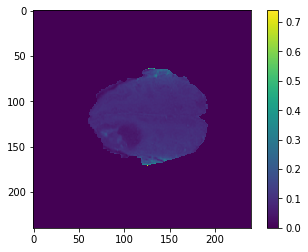

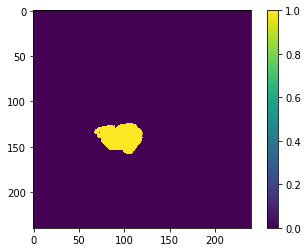

{0, 2, 3, 5, 7, 8, 9, 10, 14, 15, 16, 17, 22, 23, 24, 27, 28, 30, 36, 37, 38, 40, 41, 42, 43, 44, 45, 48, 49, 50, 52, 53, 54, 56, 57, 58, 60, 61, 62, 64, 65, 66, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}


In [6]:
X_train = train_data[0]
Y_train = train_data[1]

X_val = val_data[0]
Y_val = val_data[1]

print(X_train.shape)
print(Y_train.shape)

# This will show a slice of a patient
ind = 700
patient = X_train[ind, :, :, :]
patient_labels = Y_train[ind, :, :]
plt.imshow(patient[:, :, 0])
plt.colorbar()
plt.show()
plt.imshow(patient_labels[:, :, 1])
plt.colorbar()
plt.show()
print(train_data[2])

# New main training cell

In [7]:
# Load config file to session here
if run_on_colab:
    config_path = path + "EXJOBB/training_sessions/unet_softmax_t1ce_whole_tumor_z_score/config.json"
    weights_path = path + "EXJOBB/training_sessions/unet_softmax_t1ce_whole_tumor_z_score/weights.h5"
else:
    config_path = "config_0.json"

with open(config_path, 'r') as config_file:
    config = json.load(config_file)

# Reset file to empty loss-values and/or change paths to config and weights
reset_config(config)

print(config)

{'weights_path': '/content/my_drive/My Drive/EXJOBB/training_sessions/unet_softmax_t1ce_whole_tumor_z_score/weights.h5', 'config_path': '/content/my_drive/My Drive/EXJOBB/training_sessions/unet_softmax_t1ce_whole_tumor_z_score/config.json', 'samples_used': 90, 'keep_training': False, 'history': {'training_samples_used': 0, 'loss': [], 'val_loss': []}}


In [ ]:
import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# The path to where to save weights and initialize ModelCheckpoint
weights_path = config['weights_path']
MyModelCheckPoint = ModelCheckpoint(weights_path, verbose=0, save_weights_only=True, period=1)

log_dir=path+"EXJOBB/training_sessions/unet_softmax_t1ce_whole_tumor_z_score/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reset_config(config, config_path = config_path, weights_path=weights_path)

if config['keep_training'] == True:
    # Keep training on the old weights
    my_unet = unet(input_size = (240, 240, 1), num_classes=2, pretrained_weights = weights_path)
else:
    # Initialize network
    my_unet = unet(input_size = (240, 240, 1), num_classes=2)
    config['keep_training'] = True

assert not np.any(np.isnan(X_train)), 'Input contain nans'

#Y_train = Y_train.reshape(Y_train.shape[0], -1, 4)
validation_data = (X_val, Y_val.reshape(-1, 240**2, 2))

history = my_unet.fit(x=X_train, 
                      y=Y_train.reshape(-1, 240**2, 2), 
                      batch_size=128,
                      epochs=15, 
                      verbose=1, 
                      callbacks=[CallbackJSON(config=config), MyModelCheckPoint, es, tensorboard_callback],
                      validation_split=0.0, 
                      validation_data=validation_data, 
                      shuffle=True, 
                      class_weight=None, 
                      sample_weight=None, 
                      initial_epoch=0, 
                      steps_per_epoch=None, 
                      validation_steps=None, 
                      validation_freq=1)


First cell plots the loss and validation loss values per epoch.
Second cell plots the prediction of the current network.

In [0]:
loss = config['history']['loss']
val_loss = config['history']['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.show()

In [0]:
ind = 75
my_unet = unet(input_size=(240, 240, 1), num_classes=2, pretrained_weights=weights_path)
x = val_data[0][ind, :, :, 0].reshape(1, 240, 240, 1)
yhat = my_unet.predict(x)
yhat = yhat.reshape((240, 240, 2))
plotable = np.argmax(yhat, axis=2)
plt.imshow(plotable)
plt.colorbar()
plt.show()
plt.imshow(val_data[1][ind, :, :, 1])
plt.colorbar()
plt.show()